In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [2]:
labels = {"No One": "None",
          "Distillation (distilbert)": "Know. Distil.",
          "Pruning 0.2": "Pruning (0.2)",
            "Pruning 0.4": "Pruning (0.4)",
            "Pruning 0.6": "Pruning (0.6)",
            'Quantization  (quanto-qfloat8)': "Quantization (float8)",
            'Quantization (quanto-qfloat8)': "Quantization (float8)",
            'Quantization  (quanto-qint8)': "Quantization (int8)",
            'Quantization (quanto-qint8)': "Quantization (int8)",
            'Quantization  (quanto-qint4)': "Quantization (int4)",
            'Quantization (quanto-qint4)': "Quantization (int4)" }

df = pd.read_csv('experiment_values.csv', delimiter=';')

df["Compression Method"] = df["Compression Method"].map(labels)

methods_order = ["None"] + sorted([cm for cm in df["Compression Method"].unique() if cm != "None"])

In [3]:
def make_tables(df_, acc_metrics):
    table = df_[acc_metrics].copy(deep=True)
    # replace the highest values of each column with \textbf{value}

    for metric in table.columns:
        # calculate the percentage change
        perc = ((table[metric] / table.loc["None", metric] * 100) - 100).map(
            lambda x: f"{x:+.1f}\%"
        )
        # find best and worst values
        best = table[metric].idxmax()
        worst = table[metric].idxmin()
        #top_2 = table.loc[methods_order[1:], metric].sort_values(ascending=False)[:2]
        # format the values
        table.loc[:, metric] = table[metric].map(lambda x: f"{x:.3f}")
        # the highest value is bold
        table.loc[best, metric] = (
            "\\textbf{" + table.loc[best, metric] + "}"
        )
        # the second highest value is underlined
        table.loc[worst, metric] = (
            "\\underline{" + table.loc[worst, metric] + "}"
        )
        # add the percentage change
        table.loc[methods_order[1:], metric] = (
            table.loc[methods_order, metric] + " (" + perc + ")"
        )

    table.reset_index(inplace=True)

    table.rename(columns={c: "\\textbf{" + c + "}" for c in table.columns}, inplace=True)
    table_eff = df_[
        ["Avg Inference Time CPU", "Avg Inference Time CUDA", "Model Size"]
    ].copy(deep=True)
    for metric in  table_eff.columns:
        perc = ((table_eff[metric] / table_eff.loc["None", metric] * 100) - 100).map(lambda x: f"{x:+.1f}\%")
        #top_2 = table_eff.loc[methods_order[1:], metric].sort_values(ascending=True)[:2]
        best = table_eff[metric].idxmin()
        worst = table_eff[metric].idxmax()
        if metric == "Model Size":
            table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.0f}")
        elif metric == "Avg Inference Time CUDA":
            table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.3f}")
        else:
            table_eff.loc[:, metric] = table_eff[metric].map(lambda x: f"{x:.2f}")


        table_eff.loc[best, metric] = "\\textbf{" + table_eff.loc[best, metric] + "}"
        table_eff.loc[worst, metric] = "\\underline{" + table_eff.loc[worst, metric] + "}"
        
        table_eff.loc[methods_order[1:], metric] = table_eff.loc[methods_order, metric] + " (" + perc + ")"
    table_eff.reset_index(inplace=True)
    table_eff.rename(columns={c: "\\textbf{" + c + "}" for c in table_eff.columns}, inplace=True)
        
    return table, table_eff



# Defect Prediction

In [4]:
df_ = df[df['Task'] == 'Defect Prediction']

df_ = df_.pivot(index='Compression Method', columns='Parameter', values='Value')
df_ = df_.reindex(methods_order)

df_["Method"] = df_.index.map(lambda x: "Pruning" if x.startswith("Pruning") else ("Quantization" if x.startswith("Quantization")  else x))

## Tables

In [5]:
table, table_eff = make_tables(df_, ["Accuracy", "MCC"])

table.to_latex("tables/defect_prediction_acc.tex", escape=False, index=False)
table_eff.to_latex("tables/defect_prediction_time_size.tex", escape=False, index=False)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_73198/24435622.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_73198/24435622.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])


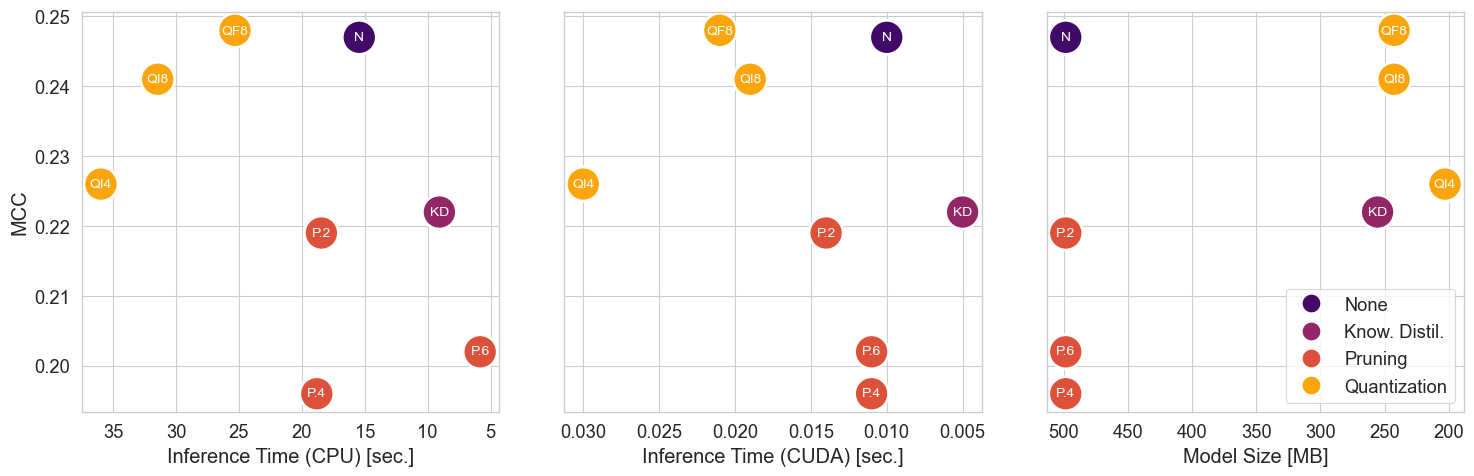

In [34]:
acronyms = {"None": "N",
            "Pruning (0.2)": "P.2",
            "Pruning (0.4)": "P.4",
            "Pruning (0.6)": "P.6",
            "Quantization (float8)": "QF8",
            "Quantization (int8)": "QI8",
            "Quantization (int4)": "QI4",
            "Know. Distil.": "KD"
            }

xlabels = {
    "Avg Inference Time CPU": "Inference Time (CPU) [sec.]",
    "Avg Inference Time CUDA": "Inference Time (CUDA) [sec.]",
    "Model Size": "Model Size [MB]",
}

df_.reset_index(inplace=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(
  ["Avg Inference Time CPU", "Avg Inference Time CUDA", "Model Size"], axs
):
  if metric != "Avg Inference Time CPU":
      # hide y label and ticks labels
      ax.set_yticklabels(["" for i in ax.get_yticklabels()])
      ax.set_ylabel(" ")

  sns.scatterplot(
      data=df_,
      x=metric,
      y="MCC",
      hue="Method",
      ax=ax,
      legend=(metric == "Model Size"),
      s=600,
      palette="inferno",
  )

  # remove the legend title if it exists
  # reduce size of the legend symbols

  if metric == "Model Size":
      ax.legend(title=None, markerscale=0.6)

  # reverse the x-axis
  ax.invert_xaxis()
  ax.set_xlabel(xlabels[metric])

  # add the acronyms to the plot
  for i, row in df_.iterrows():
      # center on the point and white font
      ax.text(
          row[metric],
          row["MCC"],
          acronyms[row["Compression Method"]],
          fontsize=10,
          ha="center",
          va="center",
          color="white",
      )
plt.tight_layout()
plt.savefig("figures/defect_prediction_tradeoff.pdf")

# Code Summarization

In [35]:
df_ = df[df["Task"] == "Summarization"]

df_ = df_.pivot(index="Compression Method", columns="Parameter", values="Value")
df_ = df_.reindex(methods_order)

df_["Method"] = df_.index.map(
    lambda x: (
        "Pruning"
        if x.startswith("Pruning")
        else ("Quantization" if x.startswith("Quantization") else x)
    )
)

In [36]:
table, table_eff = make_tables(df_, ["Bleu", "BERTScore", "SIDE"])

table.to_latex("tables/summarization_acc.tex", escape=False, index=False)
table_eff.to_latex("tables/summarization_time_size.tex", escape=False, index=False)

In [38]:
df_.reset_index(inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_73198/3314857878.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_73198/3314857878.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["" for i in ax.get_yticklabels()])


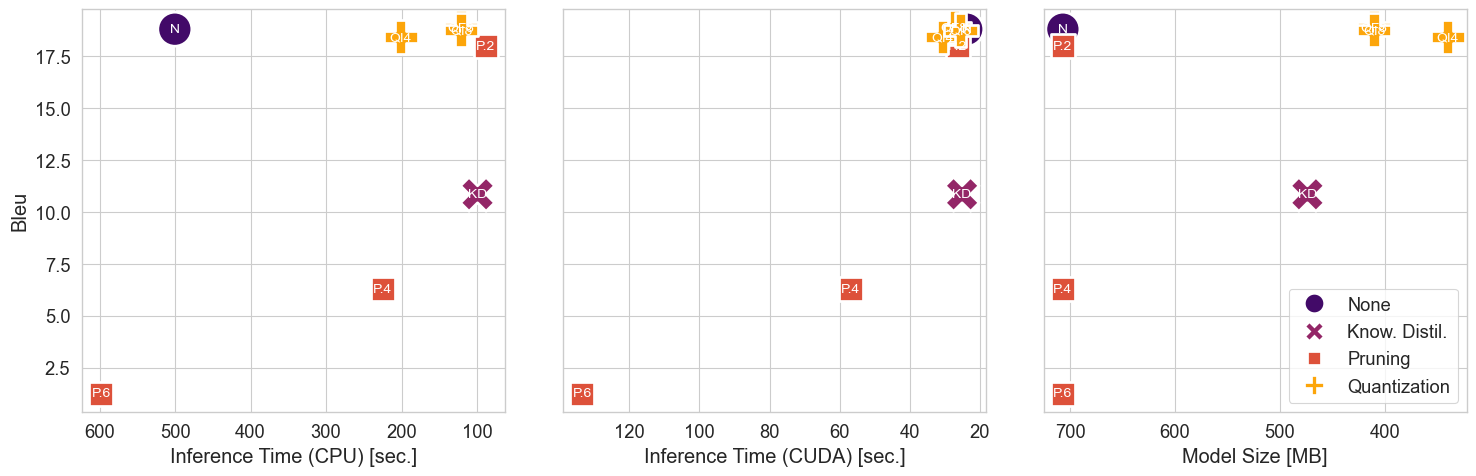

In [42]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(
    ["Avg Inference Time CPU", "Avg Inference Time CUDA", "Model Size"], axs
):
    if metric != "Avg Inference Time CPU":
        # hide y label and ticks labels
        ax.set_yticklabels(["" for i in ax.get_yticklabels()])
        ax.set_ylabel(" ")

    sns.scatterplot(
        data=df_,
        x=metric,
        y="Bleu",
        hue="Method",
        style="Method",
        ax=ax,
        legend=(metric == "Model Size"),
        s=600,
        palette="inferno",
    )

    # remove the legend title if it exists
    # reduce size of the legend symbols

    if metric == "Model Size":
        ax.legend(title=None, markerscale=0.6)

    # reverse the x-axis
    ax.invert_xaxis()
    ax.set_xlabel(xlabels[metric])

    # add the acronyms to the plot
    for i, row in df_.iterrows():
        # center on the point and white font
        ax.text(
            row[metric],
            row["Bleu"],
            acronyms[row["Compression Method"]],
            fontsize=10,
            ha="center",
            va="center",
            color="white",
        )
plt.tight_layout()
plt.savefig("figures/summarization_tradeoff.pdf")